Load packages.

In [ ]:
library(dplyr)
library(ggplot2)
library(gam)

Input the data from file. Let's look at the structure of the data.

In [2]:
ads = read.csv("ad_table.csv")
str(ads)

'data.frame':	2115 obs. of  7 variables:
 $ date              : Factor w/ 53 levels "10/1/15","10/10/15",..: 1 12 23 26 27 28 29 30 31 2 ...
 $ shown             : int  65877 65100 70658 69809 68186 66864 68227 68520 67250 67873 ...
 $ clicked           : int  2339 2498 2313 2833 2696 2617 2390 2909 2385 2614 ...
 $ converted         : int  43 38 49 51 41 46 42 46 49 42 ...
 $ avg_cost_per_click: num  0.9 0.94 0.86 1.01 1 0.98 0.94 1.07 0.88 0.93 ...
 $ total_revenue     : num  642 756 971 907 879 ...
 $ ad                : Factor w/ 40 levels "ad_group_1","ad_group_10",..: 1 1 1 1 1 1 1 1 1 1 ...


I find that the date column is treated as a factor and thus I transform it to the Date type in R for further analysis. Let's look at the first row of the data.

In [3]:
ads$date = as.Date(ads$date, "%m/%d/%y")
# ads$week_day = as.factor(format(ads$date, "%A"))
head(ads, 1)

date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad
2015-10-01,65877,2339,43,0.9,641.62,ad_group_1


Here is the summary of the data set.

In [4]:
summary(ads)

      date                shown           clicked        converted     
 Min.   :2015-10-01   Min.   :     0   Min.   :    0   Min.   :   0.0  
 1st Qu.:2015-10-14   1st Qu.: 28030   1st Qu.:  744   1st Qu.:  18.0  
 Median :2015-10-27   Median : 54029   Median : 1392   Median :  41.0  
 Mean   :2015-10-27   Mean   : 68300   Mean   : 3056   Mean   : 126.5  
 3rd Qu.:2015-11-09   3rd Qu.: 97314   3rd Qu.: 3366   3rd Qu.: 103.0  
 Max.   :2015-11-22   Max.   :192507   Max.   :20848   Max.   :1578.0  
                                                                       
 avg_cost_per_click total_revenue               ad      
 Min.   :0.000      Min.   : -200.2   ad_group_1 :  53  
 1st Qu.:0.760      1st Qu.:  235.5   ad_group_11:  53  
 Median :1.400      Median :  553.3   ad_group_12:  53  
 Mean   :1.374      Mean   : 1966.5   ad_group_13:  53  
 3rd Qu.:1.920      3rd Qu.: 1611.5   ad_group_15:  53  
 Max.   :4.190      Max.   :39623.7   ad_group_16:  53  
                         

As we can see, there are no ads shown in some records and thus they don't contain any useful information. Also, I find some records with negative total revenue, which is strange. Let's check how many such records are there.

In [5]:
table(ads$shown == 0, ads$total_revenue < 0)

       
        FALSE TRUE
  FALSE  2098    4
  TRUE     13    0

There are 13 records with no ads shown and 4 records with negative total revenue. Since this is a small part of the data, I decide not to use them here. 

In [6]:
ads = filter(ads, shown != 0 & total_revenue >= 0)

## 5 Best Ad Groups
There are in total 40 ad groups as we can see from the data structure. Here, I decide to use average click-through rate to evaluate the performance for different ad groups because it captures the growth of the company. One possible disadvantage of using click-through rate is that it does not account for profitability, which may be a problem for small companies. The 5 best ad groups are as follows.

In [7]:
ads %>%
  mutate(click_through_rate = clicked / shown) %>%
  group_by(ad) %>%
  summarize(mean_ctr = mean(click_through_rate)) %>%
  arrange(desc(mean_ctr)) %>%
  head(5)

ad,mean_ctr
ad_group_18,0.09899632
ad_group_3,0.09498652
ad_group_19,0.09418753
ad_group_26,0.09097177
ad_group_28,0.08919079


Ad group 18, 3, 19, 26 and 28 are the best 5 ad groups.

## Predicting Ads Shown on December 15th, 2015

I will use gam to fit the temporal trend. Before that, I need to transform the date column to integer values. Thus I create a new column to be the number of days since October 1st, 2015.

In [8]:
ads$t = as.integer(ads$date - as.Date('2015-10-01'))
head(ads, 1)

date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad,t
2015-10-01,65877,2339,43,0.9,641.62,ad_group_1,0


Here, I will use the first ad group as an example of how I model the temporal trend and make predictions.

In [9]:
gam_1 = gam(shown ~ s(t), data = ads, subset = ad == 'ad_group_1')
summary(gam_1)


Call: gam(formula = shown ~ s(t), data = ads, subset = ad == "ad_group_1")
Deviance Residuals:
    Min      1Q  Median      3Q     Max 
-4915.4 -1600.7  -305.7  1717.0  5896.0 

(Dispersion Parameter for gaussian family taken to be 5661996)

    Null Deviance: 424734771 on 52 degrees of freedom
Residual Deviance: 271775721 on 48 degrees of freedom
AIC: 981.2679 

Number of Local Scoring Iterations: 2 

Anova for Parametric Effects
          Df    Sum Sq  Mean Sq F value   Pr(>F)   
s(t)       1  51827235 51827235  9.1535 0.003981 **
Residuals 48 271775721  5661996                    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Anova for Nonparametric Effects
            Npar Df Npar F   Pr(F)   
(Intercept)                          
s(t)              3 5.9538 0.00155 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

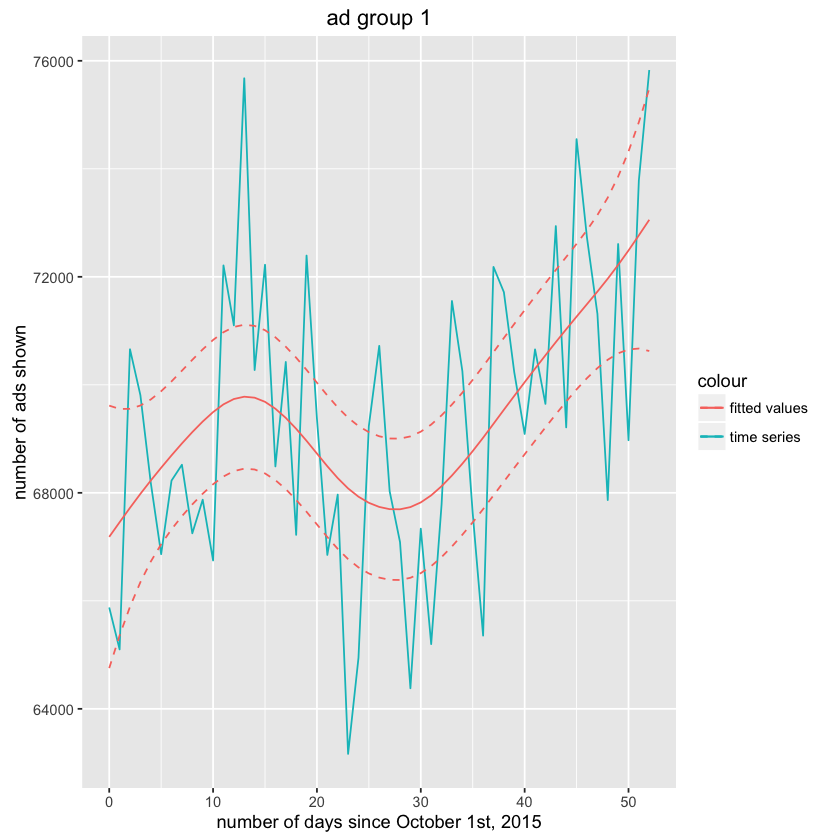

In [10]:
pred_1 = predict(gam_1, se.fit = TRUE) # fitted values with standard errors
ggplot(ads[ads$ad == 'ad_group_1', ], aes(x = t)) +
    geom_line(aes(y = shown, colour = 'time series')) +
    geom_line(aes(y = gam_1$fitted.values, colour = 'fitted values')) +
    geom_line(aes(y = gam_1$fitted.values + 2 * pred_1$se.fit, colour = 'fitted values'), 
              linetype = 'dashed') +
    geom_line(aes(y = gam_1$fitted.values - 2 * pred_1$se.fit, colour = 'fitted values'), 
              linetype = 'dashed') +
    xlab('number of days since October 1st, 2015') +
    ylab('number of ads shown') +
    ggtitle('ad group 1')

In [11]:
predict(gam_1, list(t = as.integer(as.Date('2015-12-15') - as.Date('2015-10-01'))))

1 
79686.41

Thus according to my prediction, about 79686 ads will be shown for ad group 1 on December 1st, 2015. Then I write a function based on these steps and use it to get the prediction for all ad groups.

In [12]:
pred_1215 = function(i) {
    gam_obj = gam(shown ~ s(t), data = ads, subset = ad == paste('ad_group_', i, sep = ''))
    predict(gam_obj, list(t = as.integer(as.Date('2015-12-15') - as.Date('2015-10-01'))))
}
data.frame(ad = paste('ad_group_', 1:40, sep = ''), prediction = sapply(1:40, pred_1215))

ad,prediction
ad_group_1,79686.410
ad_group_2,51942.186
ad_group_3,146521.081
ad_group_4,94799.816
ad_group_5,57684.473
ad_group_6,42674.412
ad_group_7,56804.006
ad_group_8,45832.190
ad_group_9,121114.671
ad_group_10,120601.136


## Clustering Ads into 3 Groups
For each ad group, I fit a linear model with time t as the only covariate and look at its p-value for the coefficient of time. If it's not significant with $\alpha$ level 0.05, its average cost per click is considered to be flat. Otherwise, if the coefficient of time is positive, its average cost per click is going up and if negative, going down. Similarly, I will use the first ad group as an example.

In [13]:
lm_1 = lm(avg_cost_per_click ~ t, data = ads, subset = ad == 'ad_group_1')
summary(lm_1)$coefficients

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.9472327044,0.0189030873,50.109947,4.725726e-45
t,0.0009264635,0.0006266312,1.478483,1.454287e-01


The p-value for time t is 1.45e-01, which is larger than 0.05. Thus, its average cost per click is flat. I write a function that returns 3 possible values, 1 if going up, 0 if flat and -1 if going down. Then I use this function to get the results for all ads.

In [14]:
cost_trend = function(i) {
    lm_obj = lm(avg_cost_per_click ~ t, data = ads, 
                subset = ad == paste('ad_group_', i, sep = ''))
    estimate = summary(lm_obj)$coefficients[2, 1]
    p_value = summary(lm_obj)$coefficients[2, 4]
    if (p_value >= 0.05) {
        trend = 0
    } else if (estimate > 0) {
        trend = 1
    } else {
        trend = -1
    }
    return(trend)
}
data.frame(ad = paste('ad_group_', 1:40, sep = ''), trend = sapply(1:40, cost_trend))

ad,trend
ad_group_1,0
ad_group_2,0
ad_group_3,0
ad_group_4,0
ad_group_5,0
ad_group_6,0
ad_group_7,0
ad_group_8,-1
ad_group_9,0
ad_group_10,0


In this way, I cluster the ads into 3 groups: the ones whose average cost per click is going up (trend = 1), the ones whose average cost per click is flat (trend = 0) and the ones whose average cost per click is going down (trend = -1). As we can see, most ads are flat. Ad 32 and 40 are going up, while ad 8 and 24 going down.

I have also tried Bonferroni correction, but it is less powerful and all ads are flat.
